In [1]:
# Ref: https://colab.research.google.com/drive/1Er23iD96x_SzmRG8md1kVggbmz0su_Q5#scrollTo=6J-FYdx6nFE_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My Drive/Univ Of Oulu/masters_thesis/preprocess_dataset

/content/drive/My Drive/Univ Of Oulu/masters_thesis/preprocess_dataset


In [ ]:
!pip install transformers
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.9 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 6.6 MB 49.6 MB/s 
     |████████████████████████████████| 596 kB 64.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 4.9 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=6aff53e5a5bb5c7a3c3753fb0fc200f632fc68a5ea478d1fd9803ac58669e830
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=268

In [ ]:
import torch
print('\nLoading model to GPU...')
device = torch.device('cuda')


Loading model to GPU...


In [ ]:
import pandas as pd
data = pd.read_csv("datasets/Datafiniti_Hotel_Reviews/Preprocessed_Hotel_Reviews_dataset.csv", sep=",", header=0)
data_text = data["reviews"]

In [ ]:
data.head(3)

,user,item,label,reviews,vader_negations,vader_sentiment_score
0,1,1,5,Our experience at Rancho Valencia was absolute...,0,0.5505
1,2,1,5,Amazing place. Everyone was extremely warm and...,0,0.4447
2,3,1,5,We booked a night stay at Rancho Valencia to ...,0,0.4116


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
use_fixed_padding = True

if use_fixed_padding:
    batch_size = 16
    max_len = 400

    # Tokenize all training examples
    print('Tokenizing {:,} training samples...'.format(len(data_text)))

    batches_input_ids = []
    batches_attention_masks = []
    embeddings = []
    update_interval = batch_size * 150
    for i in range(0, len(data_text), batch_size):
        # Report progress.
        if ((i % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(i))
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.batch_encode_plus(
            data_text[i:i + batch_size],  # Batch of sentences to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_len,  # Pad & truncate all sentences.
            padding='max_length',  # Pad all to the `max_length` parameter.
            truncation=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )
        # Add the encoded sentence to the list.
        batches_input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        batches_attention_masks.append(encoded_dict['attention_mask'])

Tokenizing 9,998 training samples...
  Tokenized 0 samples.
  Tokenized 2,400 samples.
  Tokenized 4,800 samples.
  Tokenized 7,200 samples.
  Tokenized 9,600 samples.


In [ ]:
# import tensorflow as tf
# bert = TFBertModel.from_pretrained('bert-base-uncased')

# # For each batch of training data...
# for step in range(0, len(batches_input_ids)):
#     b_input_ids = batches_input_ids[step]
#     b_input_masks = batches_attention_masks[step]

#     input_ids = tf.keras.layers.Input(shape=(400,), name='b_input_ids', dtype='int32')
#     mask = tf.keras.layers.Input(shape=(400,), name='b_input_masks', dtype='int32')

#     embeddings.append(bert(input_ids, attention_mask=mask)[1])
#     # print(bert(input_ids, attention_mask=mask)[1].shape)
# print(len(embeddings))

In [ ]:
from transformers import BertModel
bert = BertModel.from_pretrained('bert-base-uncased')
desc = bert.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
results = []
# For each batch of training data...
for step in range(0, len(batches_input_ids)):

    # Copy the current training batch to the GPU using the `to` method.
    b_input_ids = batches_input_ids[step].to(device)
    b_input_mask = batches_attention_masks[step].to(device)
    
    with torch.no_grad():
          outputs = bert(b_input_ids, attention_mask=b_input_mask)
    results.append(outputs[1])

In [ ]:
print(len(results))
print(results[0].shape)
print(results[0][15].shape)

625
torch.Size([16, 768])
torch.Size([768])


In [ ]:
# each product review's embedding of dimension 768 in the batch is append in emb variable. -> done for all batches 
emb = []
for i in range(len(results)):
  for j in range(len(results[i])):
    emb.append(results[i][j])
print(len(emb))

9998


In [ ]:
# my_df = pd.DataFrame(emb)
# # my_df.to_csv('bert_emb', index=False)

In [ ]:
emb[0].shape

torch.Size([768])

#### BERT embeddings dimensionality reduction using PCA

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

embs = [e.cpu().detach().numpy() for e in emb]

In [ ]:
data_len = len(data)
bert_embs = np.array(embs)
print("bert_embs.shape: ", bert_embs.shape)

bert_embs.shape:  (9998, 768)


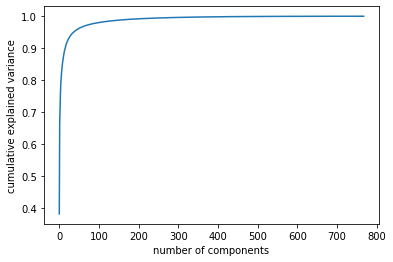

In [ ]:
pca1 = PCA().fit(bert_embs)
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

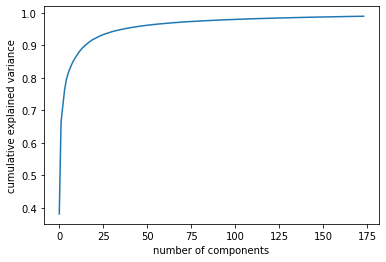

In [ ]:
pca2 = PCA(0.99)
bbb = pca2.fit_transform(bert_embs)
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

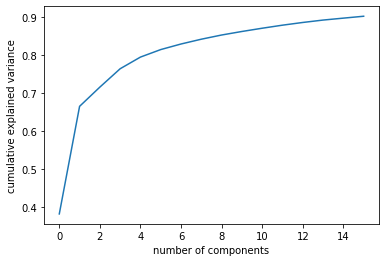

In [ ]:
pca = PCA(0.90)
bbb = pca.fit_transform(bert_embs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
n_comp = pca.n_components_
print(n_comp)
pca = PCA(n_components=n_comp)
bert_emb_pca = pca.fit_transform(bert_embs)
print("bert_emb_pca.shape: ", bert_emb_pca.shape)

16
bert_emb_pca.shape:  (9998, 16)


In [ ]:
print(pca.explained_variance_)

[7.162823   5.3107295  0.9497858  0.9065079  0.5755547  0.37068653
 0.27512163 0.23683736 0.20656788 0.17447446 0.16077587 0.15060626
 0.13355277 0.11857405 0.09520128 0.09340863]


In [ ]:
# my_df = pd.DataFrame(bert_emb_pca, columns=['review_emb1','review_emb2','review_emb3','review_emb4', 'review_emb5', 'review_emb6'])
# my_df.to_csv('bert_embs.csv', index=False)

In [ ]:
# data['review_emb1'] = bert_emb_pca[:,0]
# data['review_emb2'] = bert_emb_pca[:,1]
# data['review_emb3'] = bert_emb_pca[:,2]
# data['review_emb4'] = bert_emb_pca[:,3]
# data['review_emb5'] = bert_emb_pca[:,4]
# data['review_emb6'] = bert_emb_pca[:,5]


for i in range(n_comp):
    col_val = 'review_emb{}'.format(i+1)
    data[col_val] = bert_emb_pca[:,i]

In [ ]:
data.head(2)

,user,item,label,reviews,vader_negations,vader_sentiment_score,review_emb1,review_emb2,review_emb3,review_emb4,...,review_emb7,review_emb8,review_emb9,review_emb10,review_emb11,review_emb12,review_emb13,review_emb14,review_emb15,review_emb16
0,1,1,5,Our experience at Rancho Valencia was absolute...,0,0.5505,-0.656163,0.424873,0.762262,0.025274,...,-0.709628,0.547846,-0.421525,0.562342,0.273749,0.296355,-0.453175,0.053611,-0.703869,-0.146955
1,2,1,5,Amazing place. Everyone was extremely warm and...,0,0.4447,-0.640279,-0.745944,-1.155962,-0.188190,...,0.702138,0.269842,-0.440387,0.371404,-0.132081,0.141466,-0.395520,-0.619036,-0.464379,0.233842


In [ ]:
data.to_csv("datasets/preparation_of_datasets/hotel/new_vader/hotel_bert_emb_pca{}_senti.csv".format(n_comp), index=False)